In [1]:
from helpers import *
from sbi.analysis import pairplot
warnings.filterwarnings("ignore")

In [2]:
SEED = 2
np.random.seed(SEED)
torch.manual_seed(SEED)

subfolder = "1"
data_path = "91_param_"
# data_path =  "/p/project/icei-hbp-2023-0003/Jun/91_param_"
mini_batch_size = 125
n_sim = 13 * 125000
n_rank = 50
os.makedirs(join(data_path, subfolder, "figs"), exist_ok=True)

In [3]:
features_info = json.load(open(join(data_path, "features_info.json"), "r"))
opts = json.load(open(join(data_path, subfolder, "opts.json"), "r"))
features = list(opts.keys())
# features_info#, opts

In [4]:
def prune_features(x, threshold=0.001):

    if isinstance(x, torch.Tensor):
        x = x.numpy()
    if x.ndim == 1:
        x = x.reshape(1, -1)

    selector = VarianceThreshold(threshold=threshold)
    selector.fit(x)
    cols = selector.get_support()
    return cols


def get_features(bold, features, opts):

    if bold.ndim == 2:
        F = Features(features, opts)
        stat_vec, stat_info = F.calc_features(bold)
        return stat_vec, stat_info
    return None, None


def load_stats(rank, i_batch, data_path):
    fname = join(data_path, subfolder, "stats", f"stats_{rank:05d}_{i_batch:05d}.pkl")
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            data = pickle.load(f)
        return data['stats'], data['theta']
    else:
        return None, None


def load_stats_all(n_rank, n_batch, mini_batch_size, data_path):

    # n_batch = int(np.ceil(n_sim / n_rank/ mini_batch_size))
    Theta = []
    X = []
    for i in range(n_rank):
        for j in range(n_batch):
            stats_vec, theta_vec = load_stats(i, j, data_path)
            if stats_vec is not None:
                for k in range(len(theta_vec)):
                    if not np.isnan(stats_vec[k]).any():
                        Theta.append(theta_vec[k])
                        X.append(stats_vec[k])

    Theta = np.array(Theta).astype(np.float32)
    X = np.array(X).astype(np.float32)
    return Theta, X


def wrapper_features_all(x, info, threshold=0.001, prune_dict=None):

    flag = False
    if prune_dict is None:
        flag = True
        prune_dict = {}

    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
        if x.ndim == 1:
            x = x.reshape(1, -1)

    if flag:
        prune_dict['all'] = prune_features(x, threshold)
    x = x[:, prune_dict['all']].numpy()

    return x, prune_dict


def wrapper_features_FC(x, info, threshold=0.001, prune_dict=None):

    flag = False
    if prune_dict is None:
        flag = True
        prune_dict = {}

    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
        if x.ndim == 1:
            x = x.reshape(1, -1)
    x = slice_x(x, ['fc_corr', 'fc_homotopic', 
                    'fc_corr_0', 'fc_corr_1',
                    'fc_corr_2', 'fc_corr_3',
                    'fc_corr_4', 'fc_corr_5' ], info)

    if flag:
        prune_dict['FC'] = prune_features(x, threshold)
    x = x[:, prune_dict['FC']].numpy()

    return x, prune_dict

def wrapper_features_FCD(x, info, threshold=0.001, prune_dict=None):
    
    flag = False
    if prune_dict is None:
        flag = True
        prune_dict = {}

    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
        if x.ndim == 1:
            x = x.reshape(1, -1)
    x = slice_x(x, ['fcd_corr', 'fluidity', 'fcd_edge_var',
                    'fcd_filt_limbic', 'fcd_filt_frontal',
                    'fcd_filt_occipital', 'fcd_filt_temporal', 
                    'fcd_filt_parietal', 'fcd_filt_centralstructures',
                    'fcd_corr_0', 'fcd_corr_1', 'fcd_corr_2',
                    'fcd_corr_3', 'fcd_corr_4', 'fcd_corr_5'], info)

    if flag:
        prune_dict['FCD'] = prune_features(x, threshold)
    x = x[:, prune_dict['FCD']].numpy()

    return x, prune_dict


def wrapper_features_FC_FCD(x, info, threshold=0.001, prune_dict=None):

    flag = False
    if prune_dict is None:
        flag = True
        prune_dict = {}

    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
        if x.ndim == 1:
            x = x.reshape(1, -1)
    x = slice_x(x, ['fc_corr', 'fcd_corr', 'fluidity', 'fcd_edge_var',
                    'fc_homotopic', 'fcd_filt_limbic', 'fcd_filt_frontal',
                    'fcd_filt_occipital', 'fcd_filt_temporal', 
                    'fcd_filt_parietal', 'fcd_filt_centralstructures',
                    'fcd_corr_0', 'fcd_corr_1', 'fcd_corr_2',
                    'fcd_corr_3', 'fcd_corr_4', 'fcd_corr_5',
                    'fc_corr_0', 'fc_corr_1',
                    'fc_corr_2', 'fc_corr_3',
                    'fc_corr_4', 'fc_corr_5' ], info)

    if flag:
        prune_dict['FC_FCD'] = prune_features(x, threshold)
    x = x[:, prune_dict['FC_FCD']].numpy()

    return x, prune_dict


(1127385, 91) (1127385, 2218)
index fcd:  427728 theta max:  0.80044097


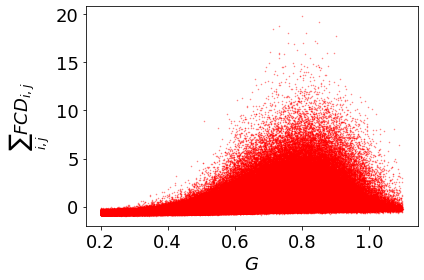

In [5]:
theta, x = load_stats_all(50, 260, mini_batch_size, data_path)
theta.shape, x.shape, type(theta), type(x), type(theta[0, 0]), type(x[0, 0])

print(theta.shape, x.shape)
# n_simulations = 10_000
# theta = theta[:n_simulations, :]
# x = x[:n_simulations, :]
# print(x.shape, theta.shape)

fcd_sum = slice_x(torch.from_numpy(x), ['fcd_sum'], features_info)
fig, ax = plt.subplots(1, figsize=(6, 4))
ax.plot(theta[:, 0], stats.zscore(fcd_sum[:, 0]), "r.", alpha=0.5, ms=1)
ax.set_xlabel(r"$G$")
ax.set_ylabel(r"$\sum_{i,j} FCD_{i,j}$")
plt.tight_layout()
plt.savefig(join(data_path, subfolder, "figs/fcd_sum.png"), dpi=300)

index_fcd = np.nanargmax(fcd_sum)
print("index fcd: ", index_fcd, "theta max: ", theta[index_fcd, 0])

if isinstance(theta, np.ndarray):
    theta = torch.from_numpy(theta)
torch.save(theta, join(data_path, subfolder, f"theta.pt"))


In [6]:
def func_select_features(func, x, features_info, subname):

    x_train, prune_dict = func(x, features_info)
    if isinstance(x_train, np.ndarray):
        x_train = torch.from_numpy(x_train)    
    torch.save(x_train, join(data_path, subfolder, f"x_{subname}.pt"))
    return prune_dict[subname]

prune_dict = {}
prune_dict["FC_FCD"] = func_select_features(wrapper_features_FC_FCD, x, features_info, "FC_FCD")
prune_dict["FC"] = func_select_features(wrapper_features_FC, x, features_info, "FC")
prune_dict["FCD"] = func_select_features(wrapper_features_FCD, x, features_info, "FCD")
prune_dict["all"] = func_select_features(wrapper_features_all, x, features_info, "all")   

with open(join(data_path, subfolder, "prune_dict.pkl"), 'wb') as f:
    pickle.dump(prune_dict, f)
del x 


In [7]:
def wrapper_train(subname):
    print(f"Training {subname}")
    x_train = torch.load(join(data_path, subfolder, f"x_{subname}.pt"))
    theta = torch.load(join(data_path, subfolder, "theta.pt"))
    prior = torch.load(join(data_path, "prior.pt"))
    posterior = train(prior, theta, x_train[:, :], n_threads=8)

    with open(join(data_path, subfolder, f"posterior_{subname}.pickle"), "wb") as cf:
        pickle.dump({"posterior": posterior}, cf)
    
# wrapper_train("FC")
# wrapper_train("FCD")
# wrapper_train("FC_FCD")
# wrapper_train("all")


Training FC
 Neural network successfully converged after 241 epochs.train Done in 8 hours 49 minutes 21.387475 seconds
Training FCD
 Neural network successfully converged after 191 epochs.train Done in 7 hours 5 minutes 53.723909 seconds
Training FC_FCD
 Neural network successfully converged after 142 epochs.train Done in 5 hours 59 minutes 29.706753 seconds
Training all
 Neural network successfully converged after 205 epochs.train Done in 9 hours 53 minutes 16.878881 seconds


In [5]:
def wrap_sim(G_obs, a_obs, b_obs, eta_obs, features, opts):
    if isinstance(eta_obs, np.ndarray):
        eta_obs = eta_obs.tolist()
    theta_obs = np.array(G_obs + a_obs + b_obs + eta_obs).reshape(1, -1)

    with open(join(data_path, "parameters.pkl"), 'rb') as f:
        parameters = pickle.load(f)
    parameters['data_path'] = data_path
    _, stat_vec, bold = wrapper_simulate(0, parameters, theta_obs.squeeze(), features, opts)
    return stat_vec, bold, theta_obs


In [11]:
SEED = 2
np.random.seed(SEED)
torch.manual_seed(SEED)

G_obs = [0.7]
a_obs = [0.2]
b_obs = [0.3]
eta_obs = np.array([-4.6]*88)
eta_obs[[0, 10, 23]] = -3.8
eta_obs[[45, 66, 78]] = -5.5

# stat_obs, bold_obs, theta_obs = wrap_sim(G_obs, a_obs, b_obs, eta_obs, features, opts)
# print(bold_obs.shape, stat_obs.shape)

In [6]:
# np.savez(join(data_path, subfolder, "bold_1.npz"), bold=bold_obs, stat_obs=stat_obs, theta_obs=theta_obs)
data = np.load(join(data_path, subfolder, "bold_1.npz"))
bold_obs = data['bold']
stat_obs = data['stat_obs']
theta_obs = data['theta_obs']

bold_obs.shape, stat_obs.shape

((88, 399), (2218,))

In [7]:
def plot_triangle(samples, G_obs, a_obs, b_obs, subname):
    fig, ax = pairplot(
        samples[:, :3],
        points=[G_obs + a_obs + b_obs],
        figsize=(8, 8),
        limits=[[0, 1.1], [0,1], [0,1]],
        labels=["G", r"$\alpha$", r"$\beta$"],
        upper='kde',
        diag='kde',
        points_colors="r",
        samples_colors="k",
        points_offdiag={'markersize': 10})
    fig.savefig(join(data_path, subfolder, f"figs/g_{subname}.png"), dpi=300, bbox_inches="tight")
    plt.close()

def plot_eta(samples, theta_obs, subname):
    eta_samples = samples[:, 3:]
    eta_true = theta_obs[0, 3:]

    _, ax = plt.subplots(1, figsize=(20, 4))
    parts = ax.violinplot(eta_samples.T, widths=0.7, showmeans=1, showextrema=1)
    ax.plot(np.r_[1:eta_true.shape[0]+1], eta_true, 'o', color='r', alpha=0.9, ms=8)
    ax.axhline(y=-4.6, color = 'gray', linestyle = '--', lw=3, alpha=0.5)
    ax.set_ylabel(' Posterior ' + r'${(\eta_i)}$')
    ax.set_xlabel('Regions')
    ax.tick_params(labelsize=14)

    for pc in parts['bodies']:
        pc.set_facecolor('green')
        pc.set_edgecolor('black')
        pc.set_alpha(0.3)
    ax.tick_params(labelsize=18)
    ax.margins(x=0.01)
    plt.savefig(join(data_path, subfolder, f"figs/eta_{subname}.png"), dpi=300, bbox_inches="tight")
    plt.close()


In [17]:
# subnames = [ "all","FC_FCD", "FCD", "FC"]
subnames = ['FC_FCD']
list_func = [
    # wrapper_features_all,
    wrapper_features_FC_FCD , 
    # wrapper_features_FCD, 
    # wrapper_features_FC
    ]

for i in range(len(subnames)):
    prune_dict = pickle.load(open(join(data_path, subfolder, f"prune_dict.pkl"), 'rb'))
    stat_obs_w = list_func[i](stat_obs, features_info, prune_dict=prune_dict)[0]
    print("stat_obs_w.shape", stat_obs_w.shape)

    # np.savez(join(data_path, subfolder, f"bold_1_{subnames[i]}.npz"),
    #          bold=bold_obs, stat_obs=stat_obs,
    #          theta=theta_obs, stat_obs_w=stat_obs_w)

    data = np.load(join(data_path, subfolder, f"bold_1_{subnames[i]}.npz"))
    bold_obs = data['bold']
    stat_obs = data['stat_obs']
    theta_obs = data['theta']
    stat_obs_w = data['stat_obs_w']
    G_obs = [theta_obs[0, 0]]
    a_obs = [theta_obs[0, 1]]
    b_obs = [theta_obs[0, 2]]
    

    posterior = pickle.load(open(join(data_path, subfolder, 
                                      f"posterior_{subnames[i]}.pickle"), "rb"))['posterior']
    
    # samples = posterior.sample((20,), x=stat_obs_w)
    # torch.save(samples, join(data_path, subfolder, f"samples_1_{subnames[i]}.pt"))
    samples = torch.load(join(data_path, subfolder, f"samples_1_{subnames[i]}.pt"))

    plot_triangle(samples, G_obs, a_obs, b_obs, subnames[i])
    plot_eta(samples, theta_obs, subnames[i])


stat_obs_w.shape (1, 352)
